In [2]:
# import libraries
import numpy as np
import pandas as pd

import os 
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
import imageio

! pip install --upgrade imgaug

# import data augmentation
import imgaug as ia
from imgaug import augmenters as iaa
# import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import imgaug.imgaug

     |████████████████████████████████| 829kB 2.8MB/s eta 0:00:01
ERROR: albumentations 0.4.3 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.3.0 which is incompatible.
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


In [3]:
# sample_submission_df = pd.read_csv("../input/severstal-steel-defect-detection/sample_submission.csv")
TRAIN_PATH = ("../input/severstal-steel-defect-detection/train_images/")
TEST_PATH = ("../input/severstal-steel-defect-detection/test_images/")

#load data frame with train lables
train_df = pd.read_csv("../input/severstal-steel-defect-detection/train.csv")
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 12568 images in the train set.
There are 1801 images in the test set.


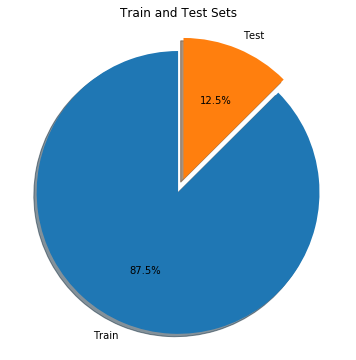

In [4]:
# plotting a pie chart which demonstrates train and test sets 
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0,0.1)

fig, ax = plt.subplots(figsize = (6,6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')
plt.show()

In [5]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [6]:
print('Ther are {} rows with empty segmentation maps.'.format(len(train_df) - train_df.EncodedPixels.count()))

Ther are 43177 rows with empty segmentation maps.


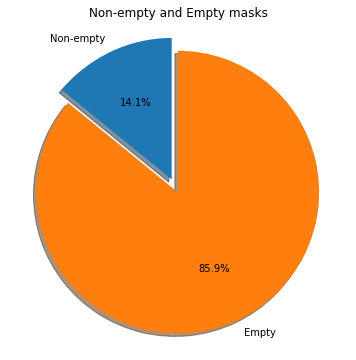

In [7]:
empty = len(train_df) - train_df.EncodedPixels.count()
nonempty = len(train_df) - empty
# plotting a pie chart which demonstrates non-empty and empty EncodedPixels 
labels = 'Non-empty', 'Empty'
sizes = [nonempty, empty]
explode = (0,0.1)

fig, ax = plt.subplots(figsize = (6,6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Non-empty and Empty masks')
plt.show()

In [8]:
# split column
split_df = train_df["ImageId_ClassId"].str.split("_", n=1, expand = True)

# add new columns to train_df
train_df['Image'] = split_df[0]
train_df['Label'] = split_df[1]

# check the result
train_df.head()

,ImageId_ClassId,EncodedPixels,Image,Label
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
4,00031f466.jpg_1,NaN,00031f466.jpg,1


In [9]:
# analyse the number of labels for each defect type
defect1 = train_df[train_df['Label'] == '1'].EncodedPixels.count()
defect2 = train_df[train_df['Label'] == '2'].EncodedPixels.count()
defect3 = train_df[train_df['Label'] == '3'].EncodedPixels.count()
defect4 = train_df[train_df['Label'] == '4'].EncodedPixels.count()

labels_per_image = train_df.groupby('Image')['EncodedPixels'].count()
no_defects = labels_per_image[labels_per_image == 0].count()

print('There are {} defect1 images'.format(defect1))
print('There are {} defect2 images'.format(defect2))
print('There are {} defect3 images'.format(defect3))
print('There are {} defect4 images'.format(defect4))
print('There are {} images with no defects'.format(no_defects))


There are 897 defect1 images
There are 247 defect2 images
There are 5150 defect3 images
There are 801 defect4 images
There are 5902 images with no defects


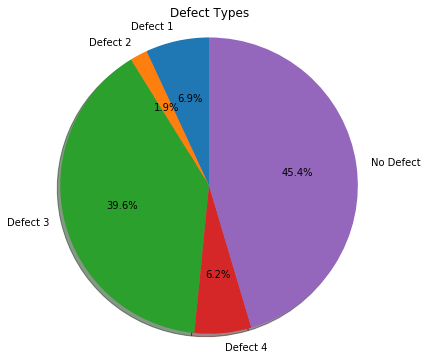

In [10]:
# plotting a pie chart which demonstrates defect types 
labels = 'Defect 1', 'Defect 2', 'Defect 3', 'Defect 4', 'No Defect'
sizes = [defect1,defect2,defect3,defect4,no_defects]
# explode = (0,0.1)

fig, ax = plt.subplots(figsize = (6,6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Defect Types')
plt.show()

In [11]:
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 0.564528962444303


Text(0.5, 1.0, 'Number of labels per image')

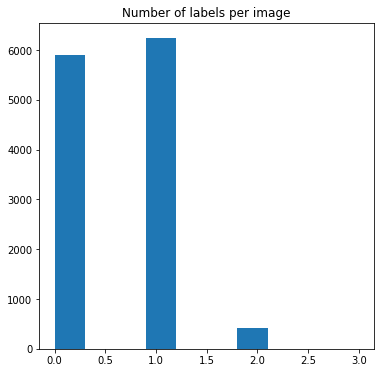

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(labels_per_image)
ax.set_title('Number of labels per image')

In [13]:
print('Ther are {} images with no labels'.format(labels_per_image[labels_per_image == 0].count()))
print('Ther are {} images with 1 label'.format(labels_per_image[labels_per_image == 1].count()))
print('Ther are {} images with 2 labels'.format(labels_per_image[labels_per_image == 2].count()))
print('Ther are {} images with 3 labels'.format(labels_per_image[labels_per_image == 3].count()))

Ther are 5902 images with no labels
Ther are 6239 images with 1 label
Ther are 425 images with 2 labels
Ther are 2 images with 3 labels


**Conclusions:**
* Almost half of the images doesn't contain any defects
* Most of the images with defects contain the defects of only one type
* In rare cases an image contains the defects of two differnt type.

In [20]:
# analyze images
from collections import defaultdict
from pathlib import Path
# train image size
train_size_dict = defaultdict(int)
train_path = Path("../input/severstal-steel-defect-detection/train_images/")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1
    
print(train_size_dict)

# test image size
test_size_dict = defaultdict(int)
test_path = Path("../input/severstal-steel-defect-detection/test_images/")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1
    
print(test_size_dict)

defaultdict(<class 'int'>, {(1600, 256): 12568})
defaultdict(<class 'int'>, {(1600, 256): 1801})


**Conclusions:**
* All the images have the same size.